# Predict next month product demands based on historical product demand

# This is Time Series Analysis. We need to import all the libraries to do our time series predictive analysis. 

In [2]:
# Just to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
sns.set()
import plotly as py
# Import dependencies
import plotly.graph_objs as go
import ipywidgets as widgets
from scipy import special
# Configure Plotly to be rendered inline in the notebook.
py.offline.init_notebook_mode(connected=True)
import itertools
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Read data set from manufacturer and explore the features

In [3]:
df = pd.read_csv('HPD2.csv', parse_dates=['Date'])
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_1507,Whse_C,Category_019,2011-09-02,1250
1,Product_0608,Whse_C,Category_001,2011-09-27,5
2,Product_1933,Whse_C,Category_001,2011-09-27,23
3,Product_0875,Whse_C,Category_023,2011-09-30,5450
4,Product_0642,Whse_C,Category_019,2011-10-31,3


In [4]:
df.columns

Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand'],
      dtype='object')

In [5]:
df.nunique()

Product_Code        2160
Warehouse              4
Product_Category      33
Date                1712
Order_Demand        3282
dtype: int64

# 1. Product Code (categorical): 2160 products
# 2. Warehouse (categorical): 4 warehouses
# 3. Product category (categorical): 33 categories¶
# 4. Date (date): demand fulfillment date
# 5. Order demanded (integer): target demand value

In [4]:
df.Product_Code.unique()

array(['Product_1507', 'Product_0608', 'Product_1933', ...,
       'Product_0465', 'Product_1013', 'Product_0853'], dtype=object)

In [5]:
df.Product_Category.unique()

array(['Category_019', 'Category_001', 'Category_023', 'Category_028',
       'Category_006', 'Category_007', 'Category_021', 'Category_004',
       'Category_015', 'Category_024', 'Category_030', 'Category_026',
       'Category_003', 'Category_018', 'Category_009', 'Category_032',
       'Category_011', 'Category_020', 'Category_013', 'Category_005',
       'Category_022', 'Category_031', 'Category_010', 'Category_033',
       'Category_017', 'Category_008', 'Category_029', 'Category_025',
       'Category_012', 'Category_014', 'Category_002', 'Category_027',
       'Category_016'], dtype=object)

In [6]:
df['Product_Category'].value_counts()

Category_019    445251
Category_005    100711
Category_001     96841
Category_007     81159
Category_021     50938
Category_006     35098
Category_028     28923
Category_011     22973
Category_015     22437
Category_024     20371
Category_009     19253
Category_026     14508
Category_030     12958
Category_032      9240
Category_022      8516
Category_023      7826
Category_018      5150
Category_003      4111
Category_013      3658
Category_020      3432
Category_031      2209
Category_033      1833
Category_008      1540
Category_012      1113
Category_010       945
Category_029       645
Category_017       602
Category_004       325
Category_002        76
Category_016        37
Category_025        35
Category_014        26
Category_027        21
Name: Product_Category, dtype: int64

In [7]:
df.groupby('Product_Category')['Order_Demand'].sum()

Product_Category
Category_001       1742936
Category_002           624
Category_003        390589
Category_004         98277
Category_005     199018205
Category_006     403610497
Category_007     128208687
Category_008         17545
Category_009       3695567
Category_010         21836
Category_011       2872254
Category_012         68278
Category_013        305830
Category_014           100
Category_015        823397
Category_016         16850
Category_017         47883
Category_018         45737
Category_019    4229890961
Category_020       2367472
Category_021       4414789
Category_022        599506
Category_023       3326785
Category_024       1045596
Category_025        486000
Category_026        279498
Category_027            80
Category_028      48165850
Category_029         23020
Category_030      40373955
Category_031         12863
Category_032       4459504
Category_033      42490000
Name: Order_Demand, dtype: int64

# We are using Category_001 as an example to predict next month product demand

# Let's make our Category_001 as a separate data frame and start preparing it for our forecast

In [9]:
Category_001 = df.loc[df['Product_Category'] == 'Category_001']

# Look at the available start and end date stamps

In [10]:
Category_001['Date'].min(), Category_001['Date'].max()

(Timestamp('2011-09-27 00:00:00'), Timestamp('2017-01-06 00:00:00'))

# Data Preprocessing - droping columns

In [11]:
cols = [ 'Product_Code', 'Warehouse', 'Product_Category']
Category_001.drop(cols, axis=1, inplace=True)
Category_001 = Category_001.sort_values('Date')
Category_001.isnull().sum()

Date            0
Order_Demand    0
dtype: int64

# We have daily data. We want to aggregate demand for Category 001 by year and month - grouping by month. 

In [12]:
Category_001[['year','month']] = Category_001.Date.apply(lambda x: pd.Series(x.strftime("%Y,%m").split(",")))
Category_001 = Category_001.groupby(['year', 'month', ])[['Order_Demand']].sum().reset_index()
Category_001=Category_001[['year', 'month', 'Order_Demand']]
Category_001

,year,month,Order_Demand
0,2011,09,28
1,2011,12,957
2,2012,01,22172
3,2012,02,25866
4,2012,03,30002
5,2012,04,20960
6,2012,05,20391
7,2012,06,21214
8,2012,07,20313
9,2012,08,18159


# Create pivot table to look at monthly product demand

In [13]:
Category_001_pivot = Category_001.pivot('month', 'year', 'Order_Demand')
Category_001_pivot

year,2011,2012,2013,2014,2015,2016,2017
month,,,,,,,
01,NaN,22172.0,22281.0,26276.0,35569.0,31214.0,29.0
02,NaN,25866.0,29030.0,26665.0,37465.0,33834.0,NaN
03,NaN,30002.0,26776.0,36264.0,34587.0,39711.0,NaN
04,NaN,20960.0,24464.0,25970.0,30803.0,32248.0,NaN
05,NaN,20391.0,21452.0,28438.0,25452.0,26485.0,NaN
06,NaN,21214.0,22989.0,29207.0,36159.0,35364.0,NaN
07,NaN,20313.0,30267.0,32801.0,34183.0,31433.0,NaN
08,NaN,18159.0,24993.0,28950.0,29797.0,26377.0,NaN
09,28.0,19864.0,27373.0,30246.0,27524.0,33249.0,NaN


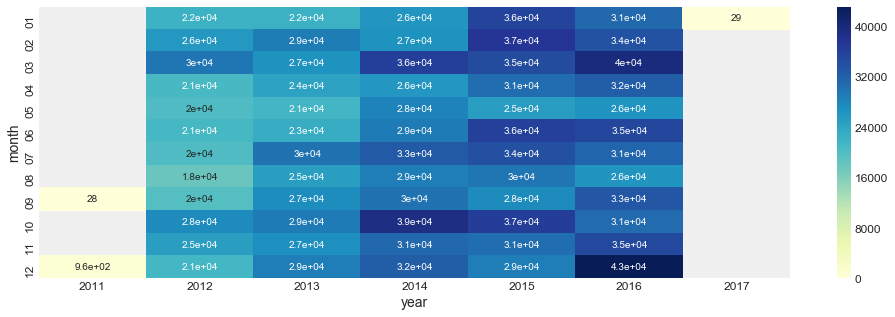

In [14]:
plt.figure(figsize=(15, 5))
sns.heatmap(Category_001_pivot, annot = True, cmap = "YlGnBu")

# Indexing with Time Series Data

In [15]:
#df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
#Category_001 = Category_001.set_index('Date')
#Category_001.index
Category_001 = Category_001.drop(Category_001.index[[0,1]])
Category_001 = Category_001.drop(Category_001.index[[-1]])
Category_001

,year,month,Order_Demand
2,2012,01,22172
3,2012,02,25866
4,2012,03,30002
5,2012,04,20960
6,2012,05,20391
7,2012,06,21214
8,2012,07,20313
9,2012,08,18159
10,2012,09,19864
11,2012,10,27648


In [16]:
month = pd.date_range('20120101', periods = 60, freq = 'M')
month

DatetimeIndex(['2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
               '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31',
               '2012-09-30', '2012-10-31', '2012-11-30', '2012-12-31',
               '2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
      

In [17]:
Category_001['Timestamp'] = month
#y = Category_001.loc[:, ('Timestamp', 'Order_Demand')]
#y.head()
#y.describe()

In [18]:
Category_001 = Category_001.set_index('Timestamp')
Category_001.index

DatetimeIndex(['2012-01-31', '2012-02-29', '2012-03-31', '2012-04-30',
               '2012-05-31', '2012-06-30', '2012-07-31', '2012-08-31',
               '2012-09-30', '2012-10-31', '2012-11-30', '2012-12-31',
               '2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
      

# Creating datetime index for the categories

In [19]:
y = Category_001.loc[:, ('Order_Demand')]
#y = Category_001.set_index('Order_Demand').resample('MS').mean()
y

Timestamp
2012-01-31    22172
2012-02-29    25866
2012-03-31    30002
2012-04-30    20960
2012-05-31    20391
2012-06-30    21214
2012-07-31    20313
2012-08-31    18159
2012-09-30    19864
2012-10-31    27648
2012-11-30    25078
2012-12-31    21271
2013-01-31    22281
2013-02-28    29030
2013-03-31    26776
2013-04-30    24464
2013-05-31    21452
2013-06-30    22989
2013-07-31    30267
2013-08-31    24993
2013-09-30    27373
2013-10-31    29258
2013-11-30    27088
2013-12-31    28882
2014-01-31    26276
2014-02-28    26665
2014-03-31    36264
2014-04-30    25970
2014-05-31    28438
2014-06-30    29207
2014-07-31    32801
2014-08-31    28950
2014-09-30    30246
2014-10-31    39195
2014-11-30    31200
2014-12-31    32328
2015-01-31    35569
2015-02-28    37465
2015-03-31    34587
2015-04-30    30803
2015-05-31    25452
2015-06-30    36159
2015-07-31    34183
2015-08-31    29797
2015-09-30    27524
2015-10-31    36550
2015-11-30    30568
2015-12-31    28926
2016-01-31    31214
2016-02-29

In [20]:
#y = Category_001['Order_Demand'].resample('MS').mean()

In [21]:
#df.index = pd.to_datetime(df.index, unit='s')

# Visualizing Furniture Sales Time Series Data

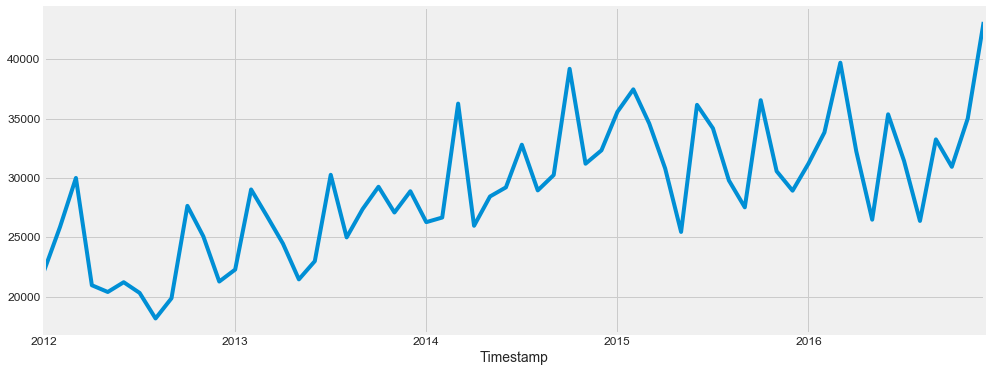

In [22]:
y.plot(figsize=(15, 6))
plt.show()

In [23]:
type(y)

pandas.core.series.Series

# Time-series decomposition plot

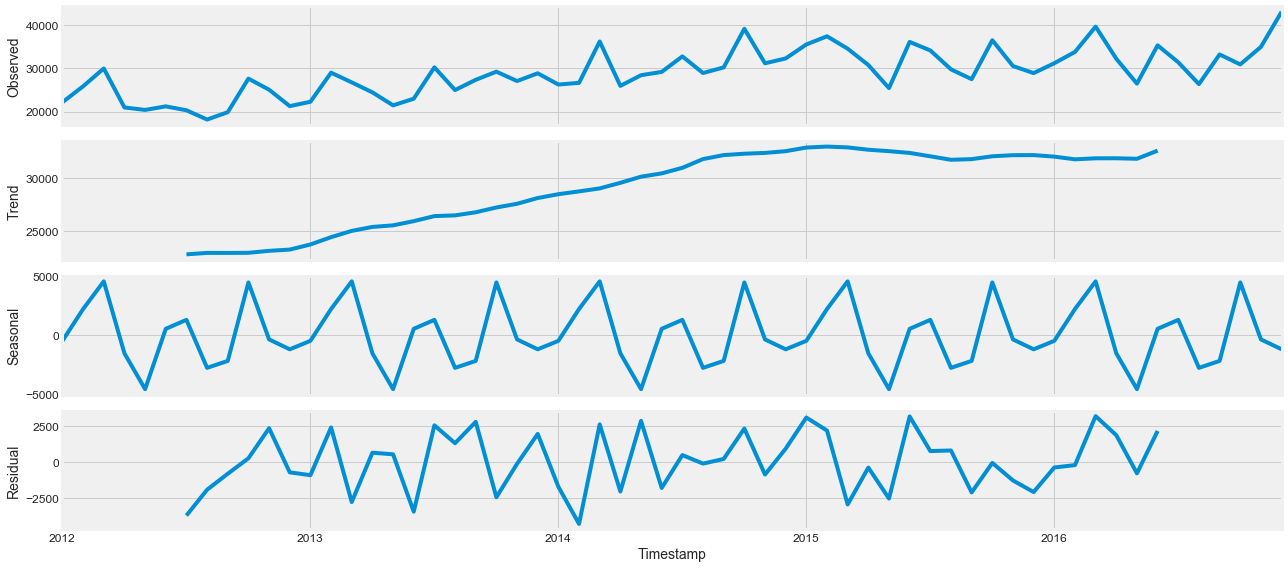

In [24]:

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
res = sm.tsa.seasonal_decompose(y.interpolate(), model='additive')
resplot = res.plot()
resplot.savefig('Seasonal_Decompose.png', dpi=150)

# Split data for each category into train and test sets - 80/20%

In [25]:
train, test = y[:48], y[:12]
train = y.loc['2012-01-31':'2015-12-31']
test = y.loc['2016-01-31':'2016-12-31']
train.shape, test.shape

((48,), (12,))

# Visualize train and test sets

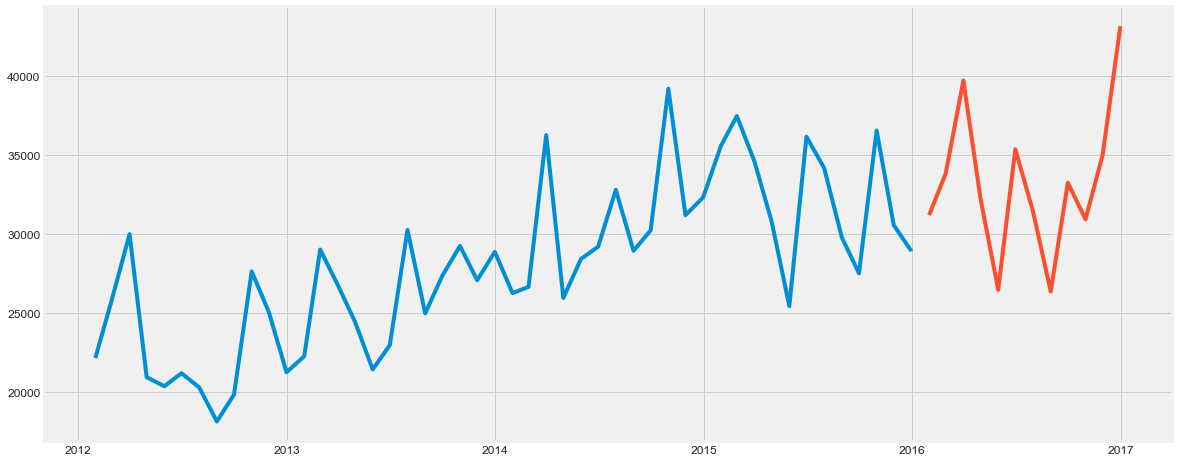

In [26]:
plt.plot(train)
plt.plot(test)
plt.show();

# Seasonal ARIMA models are denoted with the notation parameters (p, d, q) and accountable for data seasonality, trend, and noise :

In [27]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


# Find the optimal set of parameters that yields the best performance for the  model

In [28]:
minn=1000000000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if float(results.aic)<minn:
                minn=float(results.aic)
                paramm=param
                param_seasonall=param_seasonal
        except:
            continue
print('lowest AIC value is ')
print('ARIMA{}x{}12 - AIC:{}'.format(paramm, param_seasonall, minn))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1384.5013574610477
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1083.913040098839
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:942.4390582483262


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1185.7159305519572
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:954.8698329608205
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:938.4882241062174
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:724.5781974324176
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1269.5992471900065
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1323.4715859434257
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1046.0471599880216
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:921.3055361189919


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1178.9011473979363
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:956.1586508356244
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1041.6687280736417
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:722.3345076740904


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1107.9634522414938
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1155.072639660372
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:919.400190732718
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:930.9242208813536
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1303.3175869331285
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:936.4437299032916
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:916.5599592523129
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:700.138448218833


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1247.6767549894917
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1114.5902838355557
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:882.3208229753122
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:890.9093785728534


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:960.6250445310993
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:917.4485165620376
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:879.0670330071398
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:692.5609777212128


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1435.925399284364
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1176.4726752171937
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:940.5220045665517
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:937.8051364116122


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1259.1697510354102
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:936.3360137038926
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:939.0007517363811
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:697.285537930715
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1171.8372060049837
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1134.5929998936758
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:901.3829401505278
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:915.6664462401128


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1188.4844085809175
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:919.0428569367848
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:902.336550759041
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:689.6780446832137


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1889.7725811295934
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1151.344312265722
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:912.0616464840961
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:918.6843460198555


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_

ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1072.1578070793942
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:908.7832322984976
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:907.2818789323924
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:673.7085057680328


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1545.163393148109
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1116.468508981567
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:884.1949701986962
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:892.6594806297312


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1177.5175335614463
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:900.5103050505451
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:880.7968987652558
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:670.4542594479783
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1435.480643389632
lowest AIC value is 
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:670.4542594479783


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



# Fit seasonal ARIMA model

In [29]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1104      0.301     -0.366      0.714      -0.701       0.480
ma.L1         -0.6857      0.277     -2.480      0.013      -1.228      -0.144
ar.S.L12      -0.5926      0.367     -1.615      0.106      -1.312       0.127
sigma2       2.32e+07   7.77e-09   2.98e+15      0.000    2.32e+07    2.32e+07


/Users/Vsevolod/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.



# Plot diagnostics to investigate unusual model behavior 

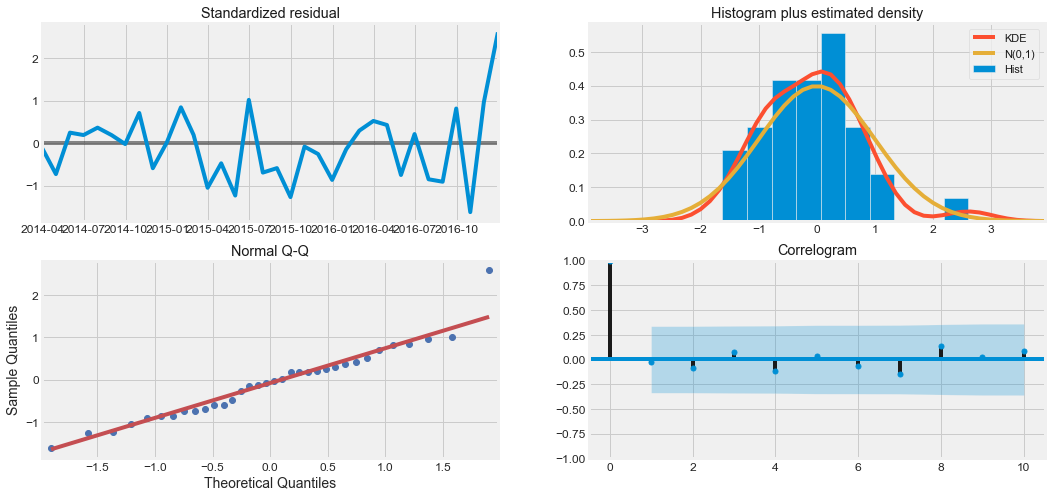

In [30]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Validate the accuracy of product demand forecast looking at predicted mean for test set of data 

            lower Order_Demand  upper Order_Demand
2016-01-31        22474.323943        41356.981985
2016-02-29        22979.493275        41862.151315
2016-03-31        27760.444652        46643.102691
2016-04-30        20757.275297        39639.933336
2016-05-31        20663.905955        39546.563994
2016-06-30        24901.229826        43783.887865
2016-07-31        26098.464494        44981.122533
2016-08-31        21318.890921        40201.548960
2016-09-30        19891.958120        38774.616158
2016-10-31        29326.923630        48209.581668
2016-11-30        20937.578296        39820.236335
2016-12-31        21151.052298        40033.710336


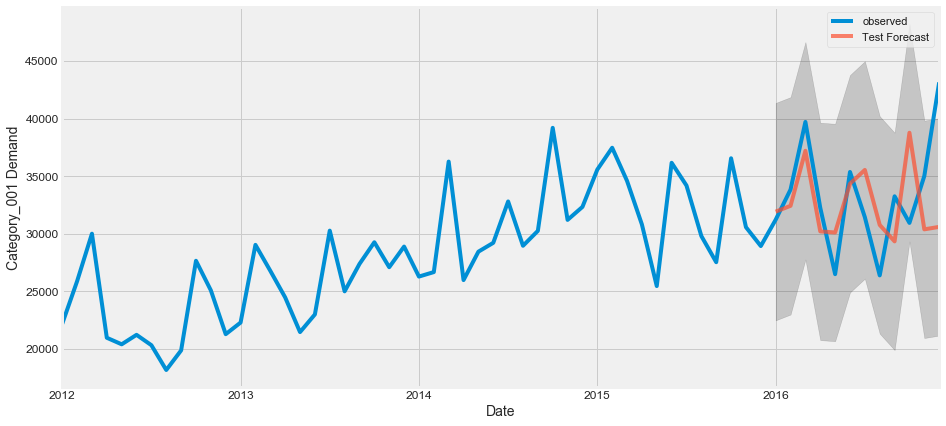

In [31]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-31'), dynamic=False)
pred_ci = pred.conf_int()
print(pred_ci)
ax = y['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Test Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Category_001 Demand')
plt.legend()
plt.show()

In [32]:
y_forecasted = pred.predicted_mean
print(y_forecasted)

2016-01-31    31915.652964
2016-02-29    32420.822295
2016-03-31    37201.773671
2016-04-30    30198.604317
2016-05-31    30105.234974
2016-06-30    34342.558846
2016-07-31    35539.793513
2016-08-31    30760.219940
2016-09-30    29333.287139
2016-10-31    38768.252649
2016-11-30    30378.907315
2016-12-31    30592.381317
Freq: M, dtype: float64


# Calculate R2 and MSE

In [33]:
from sklearn.metrics import r2_score
r2_score(test, y_forecasted)

-0.25363874987794066

In [34]:

y_forecasted = pred.predicted_mean
y_truth = y['2016-01-31':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
#print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 26571543.23


In [35]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test, y_forecasted)

26571543.23428157

# Visualizing future product demand forecast 

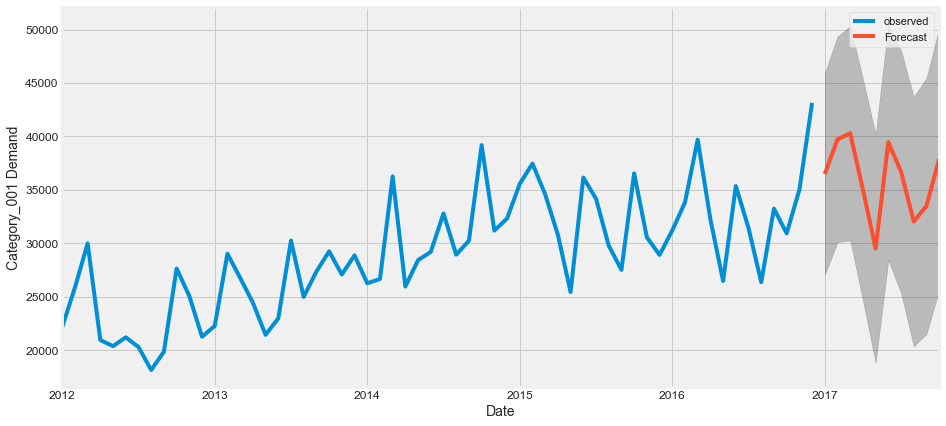

            lower Order_Demand  upper Order_Demand
2017-01-31        27050.951196        45933.609234
2017-02-28        30097.029363        49368.256183
2017-03-31        30284.236828        50327.716679
2017-04-30        24666.151908        45405.394421
2017-05-31        18806.767145        40224.218621
2017-06-30        28440.690411        50514.982976
2017-07-31        25349.159843        48061.363461
2017-08-31        20379.937137        43712.611716
2017-09-30        21530.837858        45467.906287
2017-10-31        25642.865101        50169.438107


In [36]:
pred_uc = results.get_forecast(steps=10)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Category_001 Demand')
plt.legend()
plt.show()
print(pred_ci)
print(pred_uc)

# Our Category_001 predicted demand in January 2017 

In [37]:
pred_uc.predicted_mean[0:1]

2017-01-31    36492.280215
Freq: M, dtype: float64